# Here is an exmaple of MPC controller tracking a trajectory

Here is a robot that can move in 2D plane. Objective is to track a trajectory as closely as posible. The input to the robot are the accelerations in the x and y axes.

## Importing modules

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

## Defining some parameters, robot dynamics, mpc_cost function and constraints

In [2]:
# Some parameters
dt=0.1
N = 20

# Define A and B matrix
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

B = np.array([[0.5*dt**2, 0],
              [0, 0.5*dt**2],
              [dt, 0],
              [0, dt]])


def robot_dynamics(state, control, dt):
    return A@state + B@control

# MPC cost function
def mpc_cost(U, *args):
    state, N, dt, path = args
    U = U.reshape((N, 2))  # Control inputs reshaped for each timestep
    cost = 0
    for i in range(N):
        state = robot_dynamics(state, U[i], dt)
        path_point = path[min(i, len(path)-1)]  # Current target point on path
        # Apply weights to each component of the cost function
        cost += w_pos * np.sum((state[:2] - path_point)**2)  # Weighted position error
        cost += w_ctrl * np.sum(U[i]**2)  # Weighted control effort
    return cost

# Additional constraints for speed and acceleration
def constraint(U, *args):
    _, N, dt, _ = args
    U = U.reshape((N, 2))
    constraints = []
    state = args[0]
    for i in range(N):
        state = robot_dynamics(state, U[i], dt)
        # Speed constraints
        constraints.append(state[2]**2 + state[3]**2 - v_max**2)
    return np.array(constraints)


def get_segment(arr, start, length): # Use this function when you want to wrap the path in a loop, example: a racetrack
    # Calculate the indices by creating a range and applying modulo to wrap around
    indices = (np.arange(start, start + length) % len(arr))
    # Access the elements using the calculated indices
    return arr[indices]


## Implementing MPC for following a curved trajectory 

In [3]:
# Defining the total time to run the controller for and the length of trajectory
total_time = 100
length = 10

# Maximum acceleration and speed constraints
a_max = 2.0  # Maximum acceleration
v_max = 0.5  # Maximum speed

# Define weights
w_pos = 20.0  # Weight for position error
w_ctrl = 0.1  # Weight for control effort

# Initial state [x, y, vx, vy]
x0 = np.array([0, 0, 0, 0])

# Generate points representing a curve with varying amplitude and frequency
t = np.linspace(0, 2 * np.pi, total_time)  # Parameter t from 0 to 2*pi
x = t
y = np.sin(t) * np.cos(t * 2)  # Example of a curve with varying amplitude and frequency

# Combine x and y into a 2D array
path = np.vstack((x, y)).T

# Bounds for acceleration in each direction
bounds = [(-a_max, a_max)] * (2 * N)

# Optimization to find control inputs
U_optimal = np.zeros(2*N) # Initial guess for control inputs
control_input = [np.array([0,0])]
states = [x0]
for i in range(total_time):
    constraints = ({'type': 'ineq', 'fun': constraint, 'args': (states[-1], N, dt, path[i:i+N, :])})
    result = minimize(mpc_cost, U_optimal.reshape(-1), args=(states[-1], N, dt, path[i:i+N, :]), 
                      method='SLSQP',  bounds=bounds, constraints=constraints)
    U_optimal = result.x.reshape(N, 2)
    control_input.append(U_optimal[0,:])
    new_state = robot_dynamics(states[-1], U_optimal[0,:], dt)
    states.append(new_state)
states = np.array(states)
control_input = np.array(control_input)


## Plotting the results

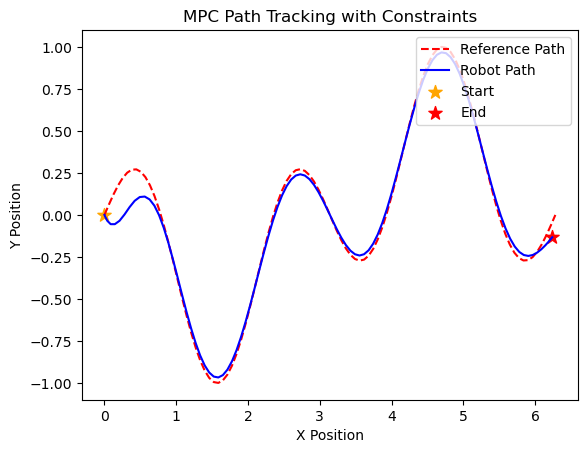

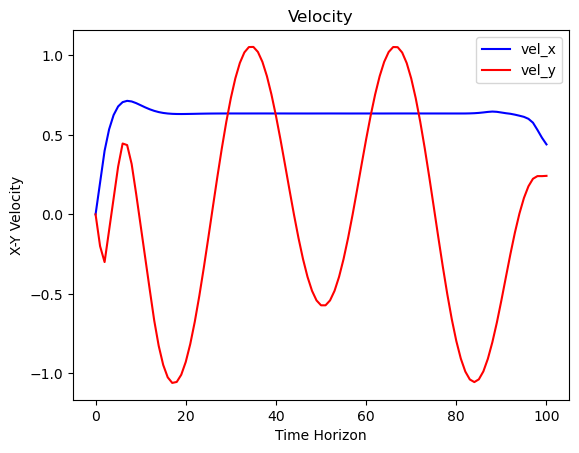

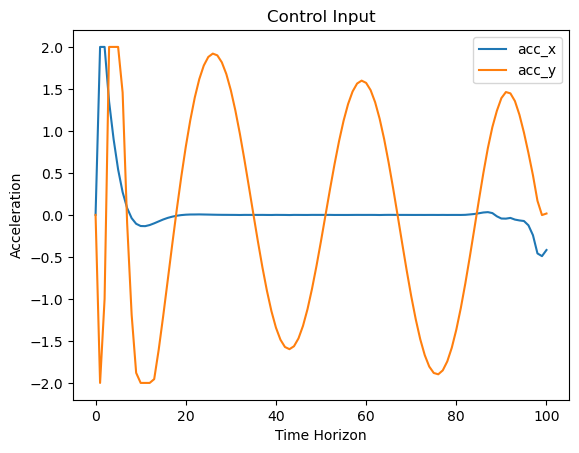

In [4]:
# Plotting the robot's path and reference path
plt.plot(path[:, 0], path[:, 1], 'r--', label='Reference Path')
plt.plot(states[:, 0], states[:, 1], 'b-', label='Robot Path')
plt.scatter(states[0,0], states[0, 1], marker='*', s=100, c='orange', label='Start')
plt.scatter(states[-1,0], states[-1, 1], marker='*', s=100, c='red', label='End')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(loc='upper right')
plt.title('MPC Path Tracking with Constraints')
plt.show()

plt.plot(states[:, 2], 'b-', label='vel_x')
plt.plot(states[:, 3], 'r-', label='vel_y')
plt.xlabel('Time Horizon')
plt.ylabel('X-Y Velocity')
plt.legend()
plt.title('Velocity')
plt.show()

plt.plot(control_input[:, 0], label = "acc_x")
plt.plot(control_input[:, 1], label = "acc_y")
plt.xlabel('Time Horizon')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Control Input')
plt.show()


## Implementing MPC for following a closed loop path, the 'get_segment()' function is used here

In [5]:
# Defining the total time to run the controller for and the length of trajectory
total_time = 100
length = 10

# Maximum acceleration and speed constraints
a_max = 5.0  # Maximum acceleration
v_max = 1.0  # Maximum speed

# Define weights
w_pos = 20.0  # Weight for position error
w_ctrl = 0.1  # Weight for control effort

# Initial state [x, y, vx, vy]
x0 = np.array([0, 0, 0, 0])

# Generate 200 points representing a circle
r = 10
theta = np.linspace(0, 2*np.pi, total_time)
x = r * np.cos(theta)
y = r * np.sin(theta)
path = np.vstack((x, y)).T

# Bounds for acceleration in each direction
bounds = [(-a_max, a_max)] * (2 * N)

# Optimization to find control inputs
U_optimal = np.zeros(2*N) # Initial guess for control inputs
control_input = [np.array([0,0])]
states = [x0]
for i in range(int(total_time*1.1)):
    constraints = ({'type': 'ineq', 'fun': constraint, 'args': (states[-1], N, dt, get_segment(path, i, N))})
    result = minimize(mpc_cost, U_optimal.reshape(-1), args=(states[-1], N, dt, get_segment(path, i, N)), 
                      method='SLSQP',  bounds=bounds, constraints=constraints)
    U_optimal = result.x.reshape(N, 2)
    control_input.append(U_optimal[0,:])
    new_state = robot_dynamics(states[-1], U_optimal[0,:], dt)
    states.append(new_state)
states = np.array(states)
control_input = np.array(control_input)


C:\Users\souro\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


## Plotting the results

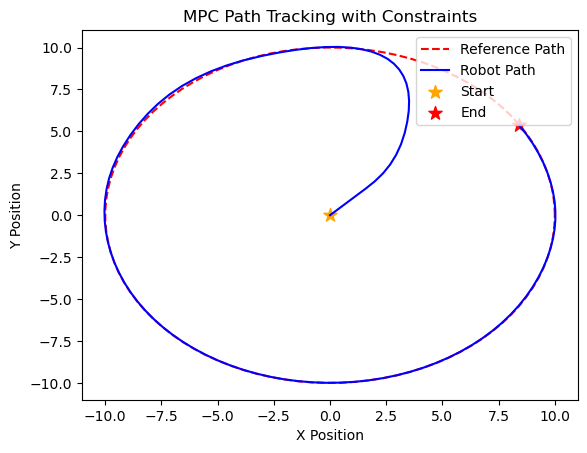

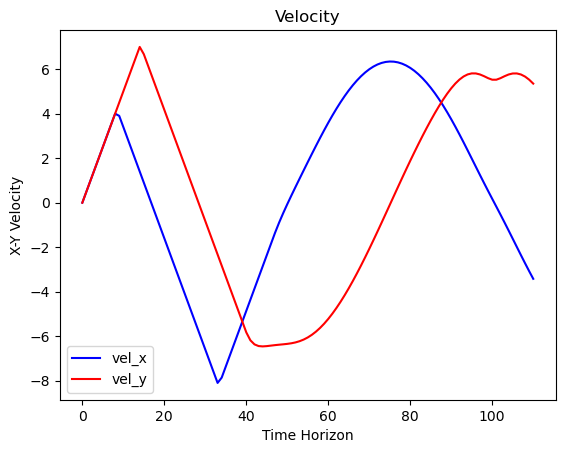

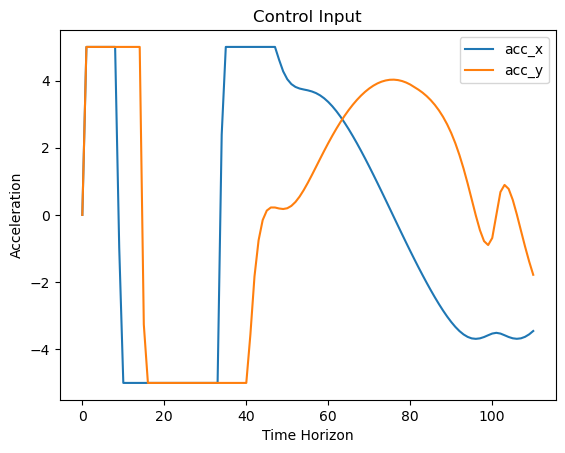

In [6]:

# Plotting the robot's path and reference path
plt.plot(path[:, 0], path[:, 1], 'r--', label='Reference Path')
plt.plot(states[:, 0], states[:, 1], 'b-', label='Robot Path')
plt.scatter(states[0,0], states[0, 1], marker='*', s=100, c='orange', label='Start')
plt.scatter(states[-1,0], states[-1, 1], marker='*', s=100, c='red', label='End')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(loc='upper right')
plt.title('MPC Path Tracking with Constraints')
plt.show()

plt.plot(states[:, 2], 'b-', label='vel_x')
plt.plot(states[:, 3], 'r-', label='vel_y')
plt.xlabel('Time Horizon')
plt.ylabel('X-Y Velocity')
plt.legend()
plt.title('Velocity')
plt.show()

plt.plot(control_input[:, 0], label = "acc_x")
plt.plot(control_input[:, 1], label = "acc_y")
plt.xlabel('Time Horizon')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Control Input')
plt.show()
